<a href="https://colab.research.google.com/github/HMercer/BacktestingForDad/blob/main/MA_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**HOW TO USE **
1. Go to box three and choose the variables you want 
2. In the toolbar above, click 'Runtime' then 'Run all'







In [145]:
#@title Run this NOW to install the relevant packages

!pip3 install fastquant
!pip install backtesting
!pip install pandas
!pip install --user pandas==0.22

In [171]:
#@title Run this NOW to import the packages into this workbook so they work within the notebook
from fastquant import get_stock_data, backtest
#Importing backtesting library
# from backtesting import Backtest, Strategy
# from backtesting.lib import crossover
# from backtesting.test import SMA, GOOG

#Importing stock data 
from pandas_datareader import data
import pandas as pd

import numpy as np

import matplotlib.colors as mcolors
import matplotlib.pyplot as pl
pl.style.use("default")

from datetime import date



In [173]:
#@title Pick variable values for the model

#@markdown Choose the stock you want to model and use it's symbol:
symbol='BP' #@param {type:"string"}

start_date = '2019-01-01' #@param {type:"date"}
#@markdown The end date is today

end_date = date.today()

#@markdown Set the amount of money you want to invest on the start date:
init_cash=500 #@param {type:"number"}

commision = 0.002 


#@markdown The output of running this cell is the data imported for your stock. This is just so you can visually check it is the right stock.

imported_stock_data = data.DataReader(symbol, 'yahoo', start_date, end_date)

dcv_data = imported_stock_data[["Close"]]
dcv_data_full = imported_stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]
dcv_data.head(-10)

,Close
Date,
2019-01-02,38.590000
2019-01-03,38.810001
2019-01-04,40.029999
2019-01-07,40.160000
2019-01-08,40.029999
2019-01-09,40.360001
2019-01-10,40.700001
2019-01-11,40.240002
2019-01-14,40.419998


In [149]:
#@title Run and Ignore
fast_periods = np.arange(1,20,1, dtype=int)
slow_periods = np.arange(20,241,5, dtype=int)

# make a grid of 0's (placeholder)
period_grid = np.zeros(shape=(len(fast_periods),len(slow_periods)))
period_grid.shape

(19, 45)

In [150]:
#@title Run and Ignore - This cell will take around 2 minutes to run as this is the model

for i,fast_period in enumerate(fast_periods): 
    for j,slow_period in enumerate(slow_periods):
        results = backtest('smac', 
                           dcv_data, 
                           fast_period=fast_period,
                           slow_period=slow_period,
                           init_cash=init_cash,
                           verbose=False, 
                           plot=False
                          )
        net_profit = results.final_value.values[0]-init_cash
        period_grid[i,j] = net_profit


In [151]:
#@title This is the total profit you'd make form the start date to now if you used the optimised model caluclated above. 
net_profit

3423.537162988186

In [152]:
#@title Run and Ignore
period_grid.min()-1

1551.4723648762701

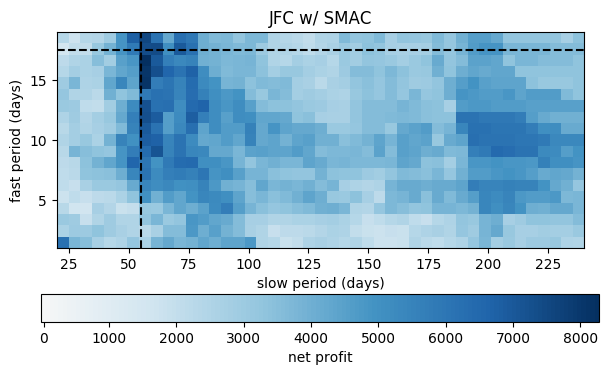

In [153]:
#@title This plot is a heatmap of all the tested short and long days and how much profit would be made using those day choices. You can see the brightest blue is the profit and the red (if any) if the loss. The intersecting hashed lines indicate the optimum short/long window choices. 
import matplotlib.colors as mcolors
import matplotlib.pyplot as pl
pl.style.use("default")

fig, ax = pl.subplots(1,1, figsize=(8,4))
xmin, xmax = slow_periods[0],slow_periods[-1]
ymin, ymax = fast_periods[0],fast_periods[-1]

#make a diverging color map such that profit<0 is red and blue otherwise
cmap = pl.get_cmap('RdBu')
norm = mcolors.DivergingNorm(vmin=np.where(period_grid.min()<0, period_grid.min(), -1), 
                             vmax = period_grid.max(), 
                             vcenter=0
                            )
#plot matrix
cbar = ax.imshow(period_grid, 
                 origin='lower', 
                 interpolation='none', 
                 extent=[xmin, xmax, ymin, ymax], 
                 cmap=cmap,
                 norm=norm
                )
pl.colorbar(cbar, ax=ax, shrink=0.9,
            label='net profit', orientation="horizontal")

# search position with highest net profit
y, x = np.unravel_index(np.argmax(period_grid), period_grid.shape)
best_slow_period = slow_periods[x]
best_fast_period = fast_periods[y]
# mark position
# ax.annotate(f"max profit={period_grid[y, x]:.0f}@({best_slow_period}, {best_fast_period}) days", 
#             (best_slow_period+5,best_fast_period+1)
#            )
ax.axvline(best_slow_period, 0, 1, c='k', ls='--')
ax.axhline(best_fast_period+0.5, 0, 1, c='k', ls='--')

# add labels
ax.set_aspect(5)
pl.setp(ax,
        xlim=(xmin,xmax),
        ylim=(ymin,ymax),
        xlabel='slow period (days)',
        ylabel='fast period (days)',
        title='JFC w/ SMAC',
       );

In [154]:
#@title This tells you the optimal short and long window.
print(f"max profit={period_grid[y, x]:.0f} @ ({best_slow_period},{best_fast_period}) days")

max profit=8282 @ (55,17) days


In [155]:
#@title Percentage of iterations that resulted in a profit
percent_positive_profit=(period_grid>0).sum()/np.product(period_grid.shape)*100
percent_positive_profit

100.0

In [156]:
#@title Percentage of iterations that resulted in breaking even
percent_breakeven=(period_grid==0).sum()/np.product(period_grid.shape)*100
percent_breakeven

0.0

In [157]:
#@title Percentage of iterations that resulted in a loss
percent_loss=(period_grid<0).sum()/np.product(period_grid.shape)*100
percent_loss

0.0

Starting Portfolio Value: 500.00
2021-02-05, ===Global level arguments===
2021-02-05, init_cash : 500
2021-02-05, buy_prop : 1
2021-02-05, sell_prop : 1
2021-02-05, commission : 0.0075
2021-02-05, stop_loss : 0
2021-02-05, stop_trail : 0
===Strategy level arguments===
fast_period : 17
slow_period : 55
2021-02-05, Final Portfolio Value: 8782.161976197958
2021-02-05, Final PnL: 8282.16
Time used (seconds): 0.15805411338806152
Number of strat runs: 1
Number of strats per run: 1
Strat names: ['smac']
**************************************************
--------------------------------------------------
Strategy Parameters	init_cash:500	buy_prop:1	sell_prop:1	commission:0.0075	stop_loss:0	stop_trail:0	execution_type:close	channel:	symbol:	allow_short:False	short_max:1.5	add_cash_amount:0	add_cash_freq:M	fast_period:17	slow_period:55
Returns	rtot:2.8658697966421065	ravg:0.005417523245070144	rnorm:2.9165683824226893	rnorm100:291.6568382422689
Sharpe	sharperatio:1.7340041431865787
Drawdown	len:7

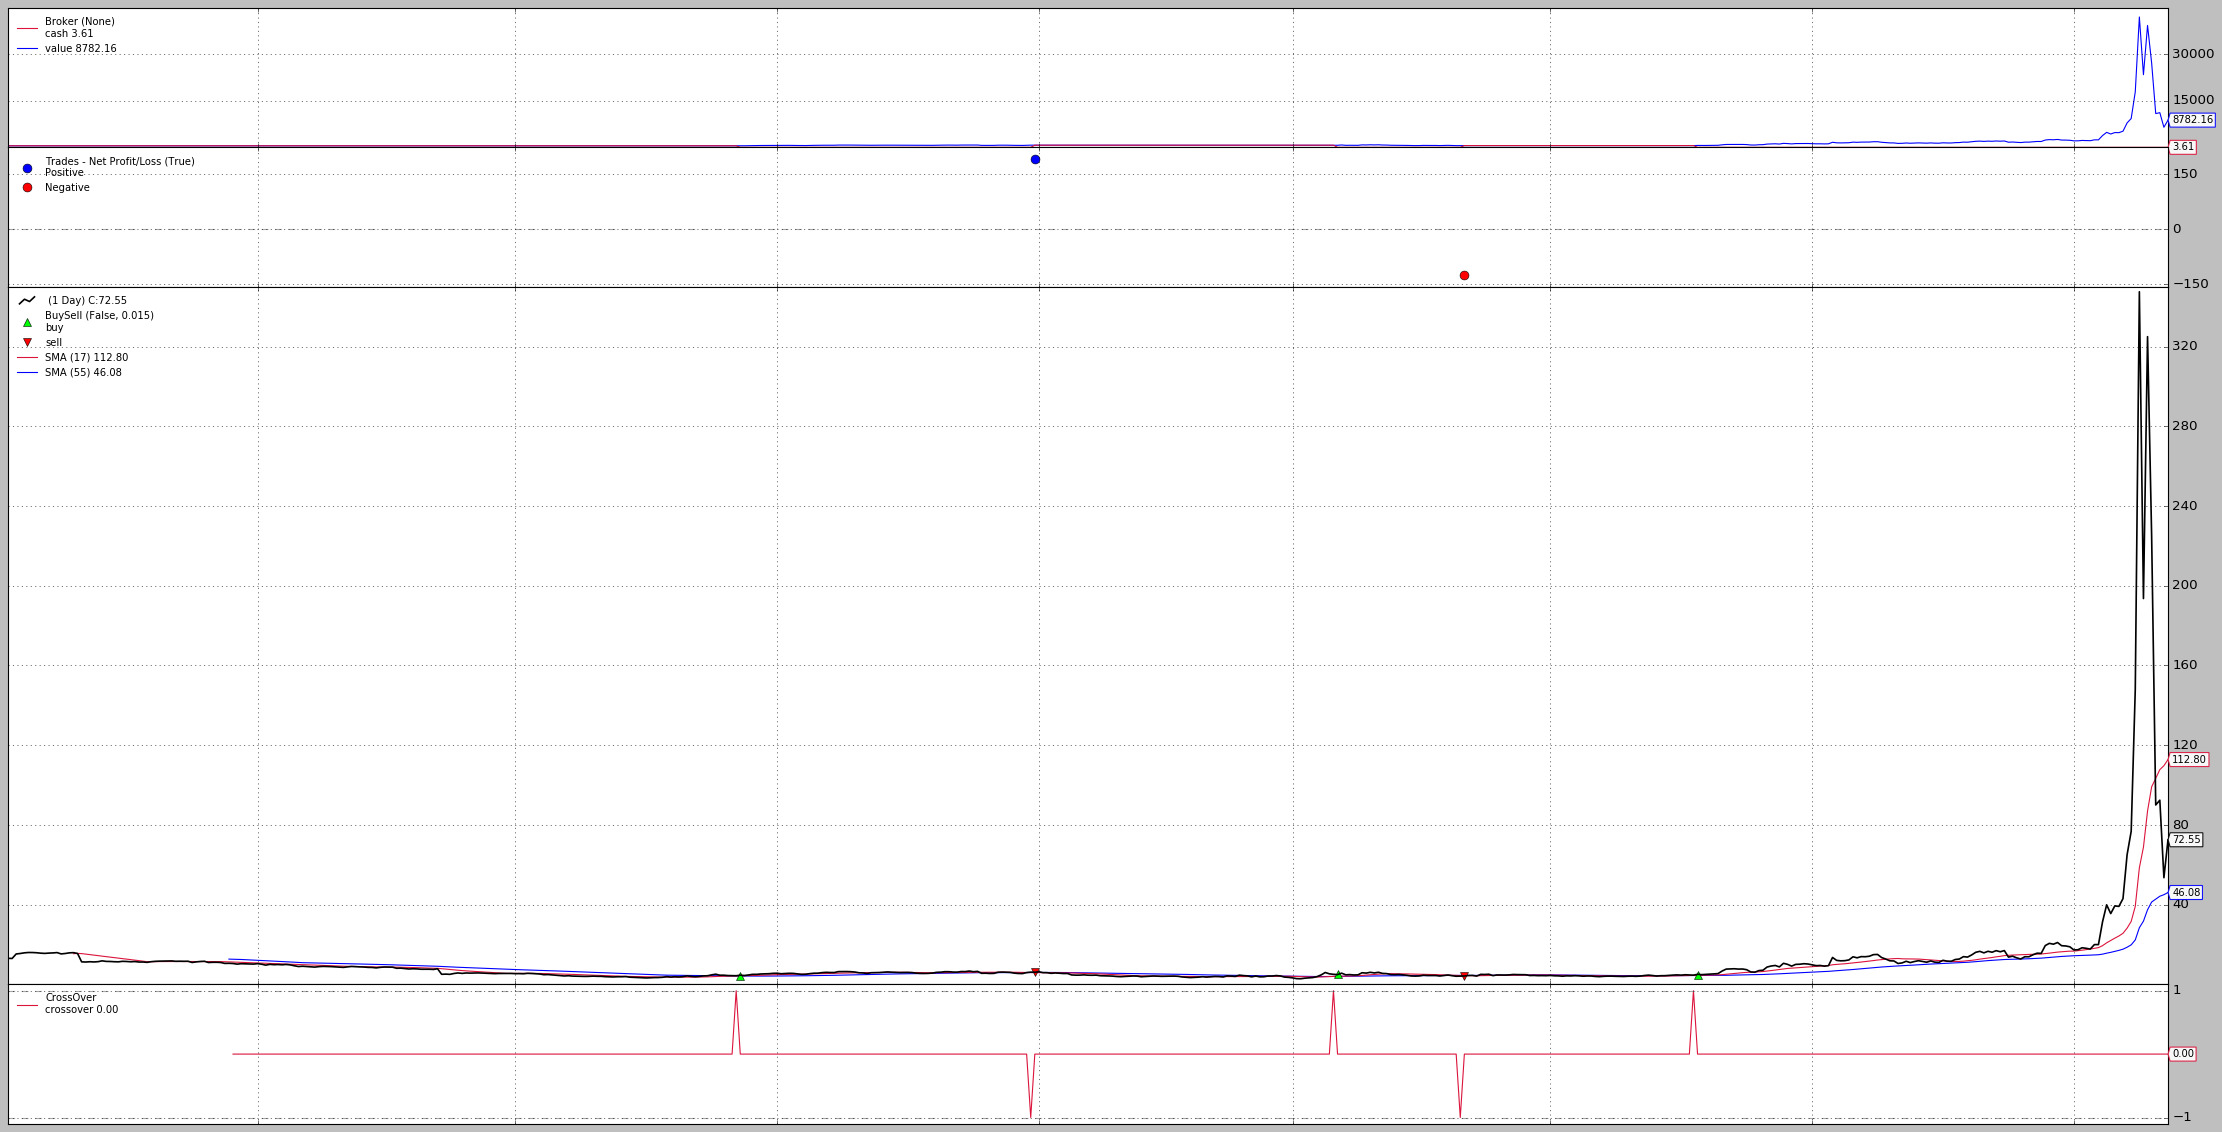

8282.161976197958

In [158]:
#@title Run and Ignore

results = backtest('smac', 
                   dcv_data, 
                   fast_period=best_fast_period, 
                   slow_period=best_slow_period, 
                   verbose=True,
                   plot=True, 
                   init_cash=init_cash)
net_profit = results.final_value.values[0]-init_cash
net_profit

In [159]:
#@title Run and Ignore

#Importing backtesting library
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

#Importing stock data 
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd

In [162]:
#@title Run and Ignore
class SmaCross(Strategy):
    n1 = best_fast_period
    n2 = best_slow_period

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()




In [163]:
#@title The plot and table shows the intricate details of buying and selling based on the OPTIMUM short and long window. 
bt = Backtest(dcv_data_full, SmaCross,
              cash=init_cash, commission=commision,
              exclusive_orders=True)

output = bt.run()
bt.plot()


In [164]:
output

Start                     2019-01-02 00:00:00
End                       2021-02-05 00:00:00
Duration                    66096000000000000
Exposure Time [%]                     66.1626
Equity Final [$]                      7026.31
Equity Peak [$]                       45177.4
Return [%]                            1305.26
Buy & Hold Return [%]                 455.088
Return (Ann.) [%]                     252.174
Volatility (Ann.) [%]                 1395.11
Sharpe Ratio                         0.180756
Sortino Ratio                         3.24339
Calmar Ratio                          2.98069
Max. Drawdown [%]                    -84.6027
Avg. Drawdown [%]                    -12.8015
Max. Drawdown Duration      14342400000000000
Avg. Drawdown Duration       1555200000000000
# Trades                                    5
Win Rate [%]                               60
Best Trade [%]                        1072.44
Worst Trade [%]                      -18.3625
Avg. Trade [%]                    

In [166]:
#@title Run and Ignore

# Initialize the short and long windows
short_window = best_fast_period
long_window = best_slow_period

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=dcv_data_full.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = dcv_data_full['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = dcv_data_full['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
signals.head(6)

,signal,short_mavg,long_mavg,positions
2019-01-02,0.0,13.070000,13.070000,NaN
2019-01-03,0.0,13.020000,13.020000,0.0
2019-01-04,0.0,13.760000,13.760000,0.0
2019-01-07,0.0,14.190000,14.190000,0.0
2019-01-08,0.0,14.514000,14.514000,0.0
2019-01-09,0.0,14.758333,14.758333,0.0


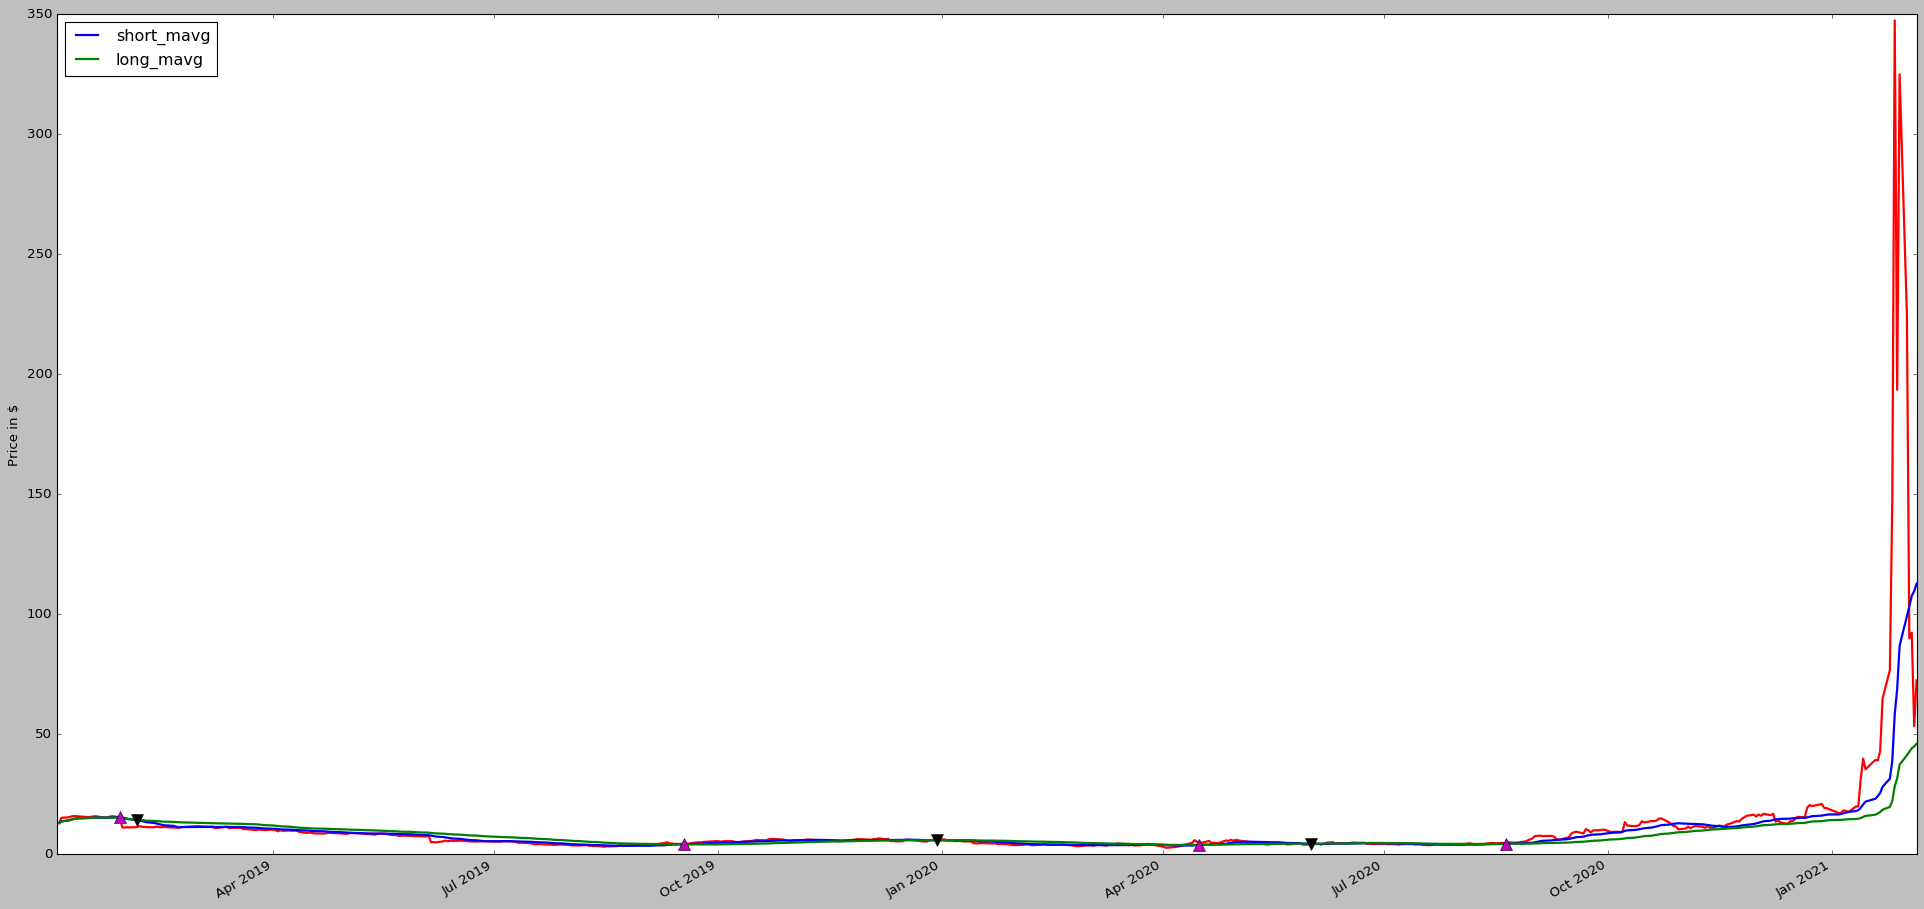

In [167]:
#@title This plot shows the buy and sell times based on the OPTIMUM model. As you can see, up=arrows indicate buy and down-arrows indicate selling.

# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
dcv_data_full['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

In [168]:
signals

,signal,short_mavg,long_mavg,positions
2019-01-02,0.0,13.070000,13.070000,NaN
2019-01-03,0.0,13.020000,13.020000,0.0
2019-01-04,0.0,13.760000,13.760000,0.0
2019-01-07,0.0,14.190000,14.190000,0.0
2019-01-08,0.0,14.514000,14.514000,0.0
2019-01-09,0.0,14.758333,14.758333,0.0
2019-01-10,0.0,14.930000,14.930000,0.0
2019-01-11,0.0,15.045000,15.045000,0.0
2019-01-14,0.0,15.111111,15.111111,0.0
2019-01-15,0.0,15.153000,15.153000,0.0


In [169]:
# np.where(signals.tail(1)['positions']=1, print('BUY'), np.where(['positions']=-1, print('SELL'), 'HOLD')

In [170]:
#@title This final cell tells you the action to take based on the model and todays data. If;
#@markdown - 0 then hold/don't buy
#@markdown - -1 then sell
#@markdown - 1 then buy

signals.tail(1)['positions']

2021-02-05    0.0
Name: positions, dtype: float64